# Deep Learning Final Project Code - Apple Stock


In [ ]:
## CHANGE THIS VALUE TO CODE FOR DESIRED STOCK (ex. Apple Inc. --> "aapl")
# unsure the exact listings the stock news dataset supports
# stock price dataset supports KRX, NASDAQ, NYSE, AMEX, and S&P500 listings
stock_code2use = "aapl"

# convert the code to all caps
stock_code2use = stock_code2use.upper()

In [ ]:
# set percent change in closing stock price (up or down) compared with the previous day that constitutes a "large change"
#   should be >=3 for practical reasons, though can be as high as you'd like
percent_cutoff = 4

# Setup

In [ ]:
# install packages, if needed
#!pip install datasets
#!pip install openai==0.28
#!pip install finance-datareader

In [ ]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
import os
from datasets import load_dataset
import FinanceDataReader as fdr
import openai

In [ ]:
## load/test OpenAI API call
# James API key
openai.api_key='***'

# turn on/off as needed
if False:
  # get user input to feed to ChatGPT
  quest = input("Ask a question: ")

  # feed user input into ChatGPT using their APU
  completion = openai.ChatCompletion.create(
      model='gpt-3.5-turbo',
      messages=[
          {'role': 'user', 'content': quest}
      ]
  )

  # print ChatGPT's output
  print(completion['choices'][0]['message']['content'])

# Import and Clean Data

## Stock News Dataset

We could also save the full, cleaned news dataset as a .csv to Google Drive if we wanted to take that approach

In [ ]:
# load whole dataset of stock news headlines into a pandas df ("train" is only existing subset)
news_dataset_object = load_dataset("NickyNicky/finance-financialmodelingprep-stock-news-sentiments-rss-feed")
raw_news_df = news_dataset_object["train"].to_pandas()

# print quick details about the whole dataset
print(raw_news_df.columns)
print(raw_news_df.shape)

# extract just the columns for stock code ("symbol"), date of publication, article title, and article text from the raw data
raw_news_df = raw_news_df[['symbol', 'publishedDate', 'title', 'text']]

# convert the "publishedDate" column to a datetime format and rename it to "date"
raw_news_df['publishedDate'] = pd.to_datetime(raw_news_df['publishedDate']).dt.date
raw_news_df.rename(columns={'publishedDate': 'date'}, inplace=True)

# print quick details about the extracted dataset
print(raw_news_df.columns)
print(raw_news_df.shape)
#raw_news_df.info()

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/142000 [00:00<?, ? examples/s]

Index(['symbol', 'publishedDate', 'title', 'image', 'site', 'text', 'url',
       'sentiment', 'sentimentScore'],
      dtype='object')
(142000, 9)
Index(['symbol', 'date', 'title', 'text'], dtype='object')
(142000, 4)


In [ ]:
## determine range of news dataset
# sort news df by days, showing the oldest and newest dates in the dataset
# it appears the dataset goes from August 12th, 2022 to October 4th, 2023
raw_news_df["date"].sort_values()

141999    2022-08-12
141929    2022-08-12
141930    2022-08-12
141931    2022-08-12
141932    2022-08-12
             ...    
311       2023-10-04
312       2023-10-04
313       2023-10-04
315       2023-10-04
0         2023-10-04
Name: date, Length: 142000, dtype: object

In [ ]:
# subset news data to just get stock of interest (note the code must be converted to all upper case)
news_df = raw_news_df[raw_news_df['symbol'] == stock_code2use]
print("This stock ("+stock_code2use+") has "+str(news_df.shape[0])+" total news articles about it in our database.")
print("First four rows of the news dataset for this stock:")
print(news_df.head(4))

This stock (AAPL) has 1221 total news articles about it in our database.
First four rows of the news dataset for this stock:
    symbol        date                                              title  \
188   AAPL  2023-10-04  Stocks edge up as bond selloff takes a break: ...   
367   AAPL  2023-10-04  7 Stocks Warren Buffett Is Loading Up on Befor...   
385   AAPL  2023-10-04  These Apple Insiders Are Selling Shares of AAP...   
441   AAPL  2023-10-04  3 Stocks That Can Withstand a Brutal Stock Mar...   

                                                  text  
188  Wall Street stocks edged up at Wednesday's ope...  
367  Warren Buffett, the legendary investor and CEO...  
385  Apple (NASDAQ:AAPL) stock is a hot topic among...  
441  Concerns about a potential stock market crash ...  


## Stock Prices Dataset

In [ ]:
# get the daily stock prices for the given stock as a pandas df, from Aug 12th, 2022 to Oct 4th, 2023 (as these are the dates we have news data for)
# includes open, high, low, close, and volume for each day the exchange was open
raw_price_df = fdr.DataReader(stock_code2use,'2022-8-12','2023-10-04')
price_df = raw_price_df.copy()

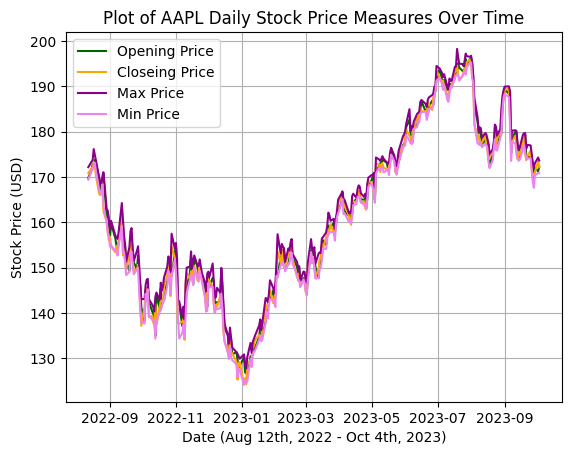

In [ ]:
# plot the stock price over the period
plt.plot(price_df['Open'], color="darkgreen", label="Opening Price");
plt.plot(price_df['Close'], color="orange", label="Closeing Price");
plt.plot(price_df['High'], color="darkmagenta", label="Max Price");
plt.plot(price_df['Low'], color="violet", label="Min Price");
plt.title("Plot of "+stock_code2use+" Daily Stock Price Measures Over Time")
plt.xlabel("Date (Aug 12th, 2022 - Oct 4th, 2023)");
plt.ylabel("Stock Price (USD)");
plt.grid();
plt.legend();

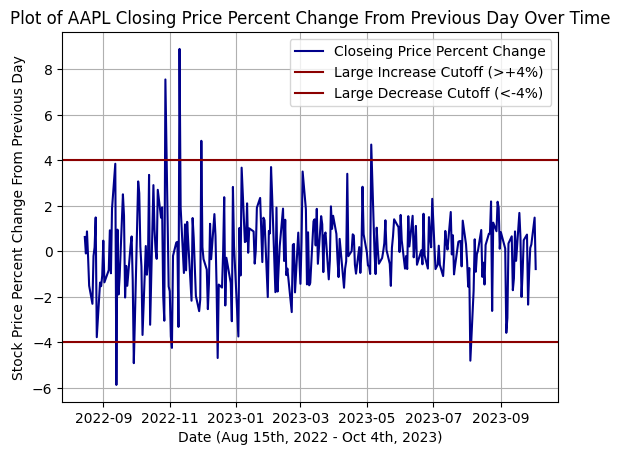

In [ ]:
# get closing time percent change from previous day
close_perc_change = (price_df["Close"][1:(price_df.shape[0])].values / price_df["Close"][0:(price_df.shape[0] - 1)].values)
close_perc_change = np.round(close_perc_change*100 - 100, 3)
close_perc_change = pd.Series(close_perc_change)
close_perc_change.index = price_df["Close"][1:len(price_df["Close"])].index

# plot the closing price percent change over the period
plt.plot(close_perc_change, color="darkblue", label="Closeing Price Percent Change");
plt.title("Plot of "+stock_code2use+" Closing Price Percent Change From Previous Day Over Time")
plt.xlabel("Date (Aug 15th, 2022 - Oct 4th, 2023)");
plt.ylabel("Stock Price Percent Change From Previous Day");
plt.grid();
plt.axhline(y=percent_cutoff, color="darkred", label="Large Increase Cutoff (>+"+str(percent_cutoff)+"%)")
plt.axhline(y=(percent_cutoff * -1), color="darkred", label="Large Decrease Cutoff (<-"+str(percent_cutoff)+"%)")
plt.legend();

# Determine Periods of Significant Stock Price Change (Down or Up) For Given Stocks

In [ ]:
# get days with a significant increase and decrease in closing stock price
sig_change = close_perc_change[(close_perc_change>percent_cutoff) | (close_perc_change<(percent_cutoff * -1))]
sig_change = pd.DataFrame(sig_change)
sig_change = sig_change.reset_index()
sig_change.columns = ["date", "percent_change"]
sig_change["date"] = pd.to_datetime(sig_change["date"]).dt.date
sig_change["num_articles"] = -1
sig_change["chatgpt_explanation"] = "NA"
print("Number of days classified to have a significant change: "+str(len(sig_change)))
print("Number of days classified to have a significant increase: "+str(sum(sig_change["percent_change"]>0)))
print("Number of days classified to have a significant decrease: "+str(sum(sig_change["percent_change"]<0)))

Number of days classified to have a significant change: 9
Number of days classified to have a significant increase: 4
Number of days classified to have a significant decrease: 5


# Determine Cause of Stock Change From News Data Using ChatGPT

Look at four days prior to day of change through three days after day of change.

(Can adjust these values as desired)

In [ ]:
# function to make the ChatGPT call
#"Summary of the Stock Price Change Causes"
def summarize(prompt): #generate summarization function
    model_engine = "text-davinci-003"
    max_tokens = 2000
    completion = openai.Completion.create(
        engine=model_engine,
        prompt=prompt,
        max_tokens=max_tokens,
        n=1,
        stop=None,
        top_p=1,
        temperature=0.5,
        frequency_penalty=0,
        presence_penalty=0
    )
    message = completion.choices[0].text
    return message.strip()

In [ ]:
# set number of days to look at before/after
num_days_prior = 4
num_days_after = 3

In [ ]:
# loop through each day of significant change, get news articles, and have ChatGPT come up with an explanation, if there are any news articles
print("Number of days classified to have a significant change: "+str(len(sig_change)))
for sig_date_i in np.arange(sig_change.shape[0]):

  # get number of headlines and explanation of change for given change
  date_start_news = sig_change["date"][sig_date_i] - datetime.timedelta(days=num_days_prior)
  date_end_news = sig_change["date"][sig_date_i] + datetime.timedelta(days=num_days_after)

  # get news data for days close to day of significant change
  news2use = news_df[(news_df["date"] > date_start_news) & (news_df["date"] < date_end_news)]

  # save the number of articles found for the given day of significant change
  sig_change.loc[sig_date_i, "num_articles"] = news2use.shape[0]

  # select columns to feed into ChatGPT
  chatgpt_news_input = news2use[["title", "text"]]

  # use the created function to call ChatGPT, if there is any data to give it
  if sig_change.loc[sig_date_i, "num_articles"] == 0:
    sig_change.loc[sig_date_i, "chatgpt_explanation"] = "[ERROR]: No articles found to feed into ChatGPT"
    print("[ERROR]: No articles found to feed into ChatGPT")
  else:
    # adjust the prompt slightly based on if there was an increase or decrease in the stock price
    if sig_change.loc[sig_date_i, "percent_change"] > 0:
      chatgpt_summary = summarize(f"Analyze the news headlines and articles to determine the cause of the rise in the stock price.\n\n{chatgpt_news_input}")
    else:
      chatgpt_summary = summarize(f"Analyze the news headlines and articles to determine the cause of the drop in the stock price.\n\n{chatgpt_news_input}")

    # save explanation in the dataframe
    sig_change.loc[sig_date_i, "chatgpt_explanation"] = chatgpt_summary

  # wait 21 seconds, as we can only make three ChatGPT requests per minute
  time.sleep(21)

Number of days classified to have a significant change: 9


In [ ]:
# set pandas display option to show the full content of each cell, then look at all of the responses
pd.set_option('display.max_colwidth', None)
sig_change
#pd.reset_option('display.max_colwidth', silent=True)

,date,percent_change,num_articles,chatgpt_explanation
0,2022-09-13,-5.868,20,"The cause of the drop in stock price is likely due to a combination of factors, including market sentiment, news headlines, and economic data. Market sentiment can be affected by news headlines, such as news of consolidation in the chip industry, the appointment of a former Apple executive to a credit card startup, and the mixed reaction to the new iPhone 14. Economic data, such as weekly jobless claims, inflation rate, and consumer inflation expectations can also affect stock prices."
1,2022-09-29,-4.912,34,"The cause of the drop in the stock price appears to be a combination of factors, including fear among US investors, the departure of a key Apple executive, lower personal consumption expenditures, reports of Apple pulling back iPhone 14 production ramp-up plans, a lower rating from Bank of America, and reports of slowing iPhone demand in China."
2,2022-10-28,7.555,32,"The cause of the rise in the stock price can be attributed to a variety of factors. These include the release of new products, better-than-expected earnings results, and positive analyst recommendations. Additionally, the company's ability to weather macroeconomic uncertainties and industry-wide softness have also been cited as factors in the rise in stock price. Finally, the introduction of new services and features, such as iMessage for Android, have also been credited with helping to boost the stock price."
3,2022-11-03,-4.240,14,"The cause of the drop in the stock price is likely due to a combination of factors, including reports of China aiming for a less disruptive coronavirus response, Apple's iPhone sales in China dropping, Apple's decision to retain Qualcomm 5G modems for iPhones, and Apple's miss on iPhone sales. Additionally, the market volatility could have also contributed to the decline in stock price."
4,2022-11-10,8.897,26,"The cause of the rise in the stock price can be attributed to a combination of factors, including positive news about Apple's products, positive news about Apple's suppliers, positive news about Apple's hiring practices, positive news about Apple's partnerships, positive news about Apple's security measures, and positive news about Apple's financials. Additionally, news about other companies, such as Tesla, Yamana Gold, and Wells Fargo, can also have a positive impact on Apple's stock price."
5,2022-11-30,4.859,37,"The cause of the rise in stock price can vary depending on the news headlines and articles. In some cases, the news may be related to a new product launch, positive earnings reports, or a positive outlook from analysts. In other cases, the news may be related to a change in company strategy, a new partnership, or a stock buyback program. Additionally, the news may be related to a specific industry trend, such as a new technology or macroeconomic event."
6,2022-12-15,-4.685,22,"The cause of the drop in the stock price is likely due to a combination of factors, including investor sentiment, market volatility, and news about Apple's products and business strategies. Investors may be concerned about Apple's ability to innovate and compete in the market, as well as its ability to manage the impact of the coronavirus pandemic on its supply chain. Additionally, news about the company's plans to allow third-party app stores on iOS, as well as reports of the iPhone's zero-day security flaw, could have caused investors to take a more cautious stance."
7,2023-05-05,4.693,27,"The cause of the rise in the stock price is likely due to a combination of news headlines and articles that reported strong earnings from Apple Inc (NASDAQ: AAPL), positive economic data, and positive reviews from Warren Buffett and other investors. The headlines and articles reported that Apple had posted strong earnings, that the US labor market was strong, and that Warren Buffett had invested in Apple stock. Additionally, articles reported that Apple had restored its iPhon

## Translation Functions: Transforming Generated Summaries into Spanish, Chinese, and Korean

In [ ]:
#helper function to translate English to Spanish
def translate_spanish(text, target_language='es'):
    """
    Translates the given text to the target language using OpenAI GPT-3.

    :param text: The text to be translated.
    :param target_language: The target language code (default is 'es' for Spanish).
    :return: Translated text.
    """
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f"Translate the following English text to {target_language}: {text}",
        max_tokens=1000, # Adjust max_tokens as needed
        n=1,
        stop=None,
        top_p=1,
        temperature=0.5,
        frequency_penalty=0,
        presence_penalty=0,
        timeout=10  # Set the timeout value in seconds
    )
    return response['choices'][0]['text']

# Assuming you have a DataFrame named 'df' with the provided data
sig_change['chatgpt_explanation_spanish'] = sig_change['chatgpt_explanation'].apply(translate_spanish)


# Assuming df is your DataFrame with the 'chatgpt_explanation_spanish' column
sig_change['chatgpt_explanation_spanish'] = sig_change['chatgpt_explanation_spanish'].str.replace('\n\n', '')


# Display the DataFrame with only the 'chatgpt_explanation_spanish' column
print(sig_change[['chatgpt_explanation_spanish']])


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          chatgpt_explanation_spanish
0                                                                                                                                 

In [ ]:
#helper function to translate English to Chinese
def translate_chinese(text, target_language='cn'):
    """
    Translates the given text to the target language using OpenAI GPT-3.

    :param text: The text to be translated.
    :param target_language: The target language code (default is 'es' for Spanish).
    :return: Translated text.
    """
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f"Translate the following English text to {target_language}: {text}",
        max_tokens=1000, # Adjust max_tokens as needed
        n=1,
        stop=None,
        top_p=1,
        temperature=0.5,
        frequency_penalty=0,
        presence_penalty=0,
        timeout=10  # Set the timeout value in seconds
    )
    return response['choices'][0]['text']

In [ ]:
# Assuming you have a DataFrame named 'df' with the provided data
sig_change['chatgpt_explanation_chinese'] = sig_change['chatgpt_explanation'].apply(translate_chinese)


# Assuming df is your DataFrame with the 'chatgpt_explanation_chinese' column
sig_change['chatgpt_explanation_chinese'] = sig_change['chatgpt_explanation_chinese'].str.replace('\n\n', '')

# Display the DataFrame with only the 'chatgpt_explanation_chinese' column
print(sig_change[['chatgpt_explanation_chinese']])

                                                                                                                                                                                            chatgpt_explanation_chinese
0                                                                       由于市场情绪、新闻标题和经济数据等多种因素，股票价格的下跌可能是由于这些因素的综合影响。市场情绪可能受到新闻标题的影响，例如芯片行业整合的新闻、前苹果高管被任命到一家信用卡初创公司以及对新iPhone 14的混合反应。经济数据，如每周失业索赔、通胀率和消费者通胀预期，也会影响股票价格。
1                                                                                                              看来股价下跌的原因是多方面因素的结合，包括美国投资者的恐惧，苹果关键高管的离职，个人消费支出的下降，有关苹果收回iPhone 14生产增长计划的报道，美国银行的较低评级以及有关中国iPhone需求放缓的报道。
2                                                                           导致股票价格上涨的原因可以归因于多种因素。其中包括发布新产品，超预期的收益结果以及积极的分析师推荐。此外，该公司应对宏观经济不确定性和行业软弱性的能力也被提及为股票价格上涨的因素。最后，引入新的服务和功能，如iMessage for Android，也被认为有助于提振股票价格。
3                                                                                         股价下跌的原因可能是多种因素共同作用的结果，包括有关中国采取更不激进的疫情应对的报道、苹果在

In [ ]:
#helper function to translate English to Korean
def translate_korean(text, target_language='ko'):
    """
    Translates the given text to the target language using OpenAI GPT-3.

    :param text: The text to be translated.
    :param target_language: The target language code (default is 'es' for Spanish).
    :return: Translated text.
    """
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f"Translate the following English text to {target_language}: {text}",
        max_tokens=1000, # Adjust max_tokens as needed
        n=1,
        stop=None,
        top_p=1,
        temperature=0.5,
        frequency_penalty=0,
        presence_penalty=0,
        timeout=10  # Set the timeout value in seconds
    )
    return response['choices'][0]['text']

In [ ]:
# Assuming you have a DataFrame named 'df' with the provided data
sig_change['chatgpt_explanation_korean'] = sig_change['chatgpt_explanation'].apply(translate_korean)


# Assuming df is your DataFrame with the 'chatgpt_explanation_korean' column
sig_change['chatgpt_explanation_korean'] = sig_change['chatgpt_explanation_korean'].str.replace('\n\n', '')

# Display the DataFrame with only the 'chatgpt_explanation_korean' column
print(sig_change[['chatgpt_explanation_korean']])

                                                                                                                                                                                                                                                                                                          chatgpt_explanation_korean
0                                                                                     주가 하락의 원인은 시장 분위기, 뉴스 헤드라인, 그리고 경제 데이터 등의 여러 요인이 결합되어 인한 것으로 보입니다. 시장 분위기는 칩 업계 합병 뉴스, 신용 카드 스타트업에 애플 이전 이사를 임명하는 뉴스, 그리고 신제품 iPhone 14에 대한 반응이 갈린 뉴스 등으로 영향을 받을 수 있습니다. 경제 데이터는 주간 비재산자 수요, 인플레이션 비율, 그리고 소비자 인플레이션 예상 등이 주가에도 영향을 미칠 수 있습니다.
1                                                                                                                                                                                       주가 하락의 원인은 미국 투자자들의 두려움, 애플의 핵심 경영진의 떠남, 개인 소비 지출 감소, 애플이 아이폰 14 생산 계획 강화를 중단한 보고, 뱅크 오브 아메리카의 낮은 등급 및 중국 아이폰 수요 감소 보고를 포함한 여러 요인의 조합으로 보인다.
2                        

## Final output

In [ ]:
sig_change.head()

,date,percent_change,num_articles,chatgpt_explanation,chatgpt_explanation_spanish,chatgpt_explanation_chinese,chatgpt_explanation_korean
0,2022-09-13,-5.868,20,"The cause of the drop in stock price is likely due to a combination of factors, including market sentiment, news headlines, and economic data. Market sentiment can be affected by news headlines, such as news of consolidation in the chip industry, the appointment of a former Apple executive to a credit card startup, and the mixed reaction to the new iPhone 14. Economic data, such as weekly jobless claims, inflation rate, and consumer inflation expectations can also affect stock prices.","La causa de la baja en el precio de las acciones probablemente se deba a una combinación de factores, incluyendo el sentimiento del mercado, los titulares de noticias y los datos económicos. El sentimiento del mercado puede verse afectado por los titulares de noticias, como las noticias de consolidación en la industria de chips, la designación de un ex ejecutivo de Apple a una start-up de tarjetas de crédito y la reacción mixta al nuevo iPhone 14. Los datos económicos, como las solicitudes semanales de desempleo, la tasa de inflación y las expectativas de inflación de los consumidores, también pueden afectar los precios de las acciones.",由于市场情绪、新闻标题和经济数据等多种因素，股票价格的下跌可能是由于这些因素的综合影响。市场情绪可能受到新闻标题的影响，例如芯片行业整合的新闻、前苹果高管被任命到一家信用卡初创公司以及对新iPhone 14的混合反应。经济数据，如每周失业索赔、通胀率和消费者通胀预期，也会影响股票价格。,"주가 하락의 원인은 시장 분위기, 뉴스 헤드라인, 그리고 경제 데이터 등의 여러 요인이 결합되어 인한 것으로 보입니다. 시장 분위기는 칩 업계 합병 뉴스, 신용 카드 스타트업에 애플 이전 이사를 임명하는 뉴스, 그리고 신제품 iPhone 14에 대한 반응이 갈린 뉴스 등으로 영향을 받을 수 있습니다. 경제 데이터는 주간 비재산자 수요, 인플레이션 비율, 그리고 소비자 인플레이션 예상 등이 주가에도 영향을 미칠 수 있습니다."
1,2022-09-29,-4.912,34,"The cause of the drop in the stock price appears to be a combination of factors, including fear among US investors, the departure of a key Apple executive, lower personal consumption expenditures, reports of Apple pulling back iPhone 14 production ramp-up plans, a lower rating from Bank of America, and reports of slowing iPhone demand in China.","La causa de la caída en el precio de las acciones parece ser una combinación de factores, incluyendo el temor entre los inversores estadounidenses, la salida de un ejecutivo clave de Apple, menores gastos de consumo personal, informes de que Apple ha retrasado los planes de producción del iPhone 14, una calificación más baja de Bank of America y informes de una demanda de iPhone disminuyendo en China.",看来股价下跌的原因是多方面因素的结合，包括美国投资者的恐惧，苹果关键高管的离职，个人消费支出的下降，有关苹果收回iPhone 14生产增长计划的报道，美国银行的较低评级以及有关中国iPhone需求放缓的报道。,"주가 하락의 원인은 미국 투자자들의 두려움, 애플의 핵심 경영진의 떠남, 개인 소비 지출 감소, 애플이 아이폰 14 생산 계획 강화를 중단한 보고, 뱅크 오브 아메리카의 낮은 등급 및 중국 아이폰 수요 감소 보고를 포함한 여러 요인의 조합으로 보인다."
2,2022-10-28,7.555,32,"The cause of the rise in the stock price can be attributed to a variety of factors. These include the release of new products, better-than-expected earnings results, and positive analyst recommendations. Additionally, the company's ability to weather macroeconomic uncertainties and industry-wide softness have also been cited as factors in the rise in stock price. Finally, the introduction of new services and features, such as iMessage for Android, have also been credited with helping to boost the stock price.","La causa del aumento en el precio de las acciones se puede atribuir a una variedad de factores. Estos incluyen el lanzamiento de nuevos productos, resultados de ganancias mejores de lo esperado y recomendaciones positivas de los analistas. Además, la capacidad de la empresa para hacer frente a las incertidumbres macroeconómicas y la debilidad generalizada en la industria también se han citado como factores en el aumento del precio de las acciones. Finalmente, la introducción de nuevos servicios y características, como iMessage para Android, también se han acreditado con ayudar a impulsar el precio de las acciones.",导致股票价格上涨的原因可以归因于多种因素。其中包括发布新产品，超预期的收益结果以及积极的分析师推荐。此外，该公司应对宏观经济不确定性和行业软弱性的能力也被提及为股票价格上涨的因素。最后，引入新的服务和功能，如iMessage for Android，也

In [ ]:
## Download the output as a csv file
sig_change.to_csv('Stock_price_summary_aapl.csv', index=False,encoding='utf-8-sig')